In [35]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, diags, csc_matrix, triu

from scipy.sparse.linalg import eigsh, expm_multiply
from scipy.optimize import minimize as minimize

from jax import jit

import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd#, jacrev
from jax.scipy.linalg import expm

from jax.lax import fori_loop

from BuildLattices import *

In [7]:
# let's build a 1D lattice (with unit-cell two.)

# Ruby lattice
uc = np.array([
            [0,0],
            [1,0]
    ])

lv = np.array([
                  [2,0],
                  [0,0],
])

latpoints = np.array([
                [1/2, 0],
                [3/2, 0]                   
])

lat_far = Lattice2D(uc, lv, latpoints, 6, 1, 1.2)
lat_far.make_positions()
lat_far.build_operators()
lat_far.build_LR_hamiltonian()
lat_far.build_translation_isometry()

lat_far.sym_iso

<322x60 sparse matrix of type '<class 'numpy.float64'>'
	with 322 stored elements in Compressed Sparse Row format>

In [8]:
def build_evolution(hyperparams):
    ndiscr_per_step = hyperparams["ndiscr_per_step"]
    ncycles = hyperparams["ncycles"]

    T0 = hyperparams["T0"]

    # Let's construct the Hamiltonian and diagonalize it here.
    lat = hyperparams["lat"]
    hx_sym = lat.sym_iso.conj().T @ lat.hx @ lat.sym_iso
    ntot_sym = lat.sym_iso.conj().T @ lat.ntot @ lat.sym_iso

    hx_l, hx_U = np.linalg.eigh(hx_sym.todense())
    ntot_l, ntot_U = np.linalg.eigh(ntot_sym.todense())

    psi0 = hyperparams["psi0"] # initalize z2 state here

    # these are some fixed pulse parameters
    T = np.pi * 1.51 * T0
    tau_list = jnp.array([1]) * (T/2)

    # any variational (input) parameters should be included in params.
    def apply_evolution(params, args):

        def apply_cycle(t, psi):
            # load from params what we want to do at tstep t
            tau = tau_list[0] / ndiscr_per_step
            det = params[t]

            # apply the resulting evolution.
            Rx = hx_U @ jnp.diag(jnp.exp(-1j * tau * hx_l)) @ hx_U.conj().T
            Udet = ntot_U @ jnp.diag(jnp.exp(-1j * det * ntot_l)) @ ntot_U.conj().T

            return jnp.dot(Udet, jnp.dot(Rx, psi))

        
        psi = jnp.copy(psi0)

        psi_list = []
        for n in range(ncycles):
            psi = fori_loop(0, ndiscr_per_step, apply_cycle, psi) 
            psi_list.append(jnp.copy(psi))

        # here, we return a list of the evolved states
        # that way we can compute e.g. a time-integrated variance
        return psi_list
    
    return jit(apply_evolution)


In [28]:
# 
def build_loss(hyperparams):

    # generate observables of interest here.
    lat = hyperparams["lat"]

    Sz = lat.n_sublat[0] - lat.n_sublat[1] # this is like Sz right?
    Sz2 = Sz @ Sz

    Sz = (lat.sym_iso.conj().T @ Sz @ lat.sym_iso).todense()
    Sz2 = (lat.sym_iso.conj().T @ Sz2 @ lat.sym_iso).todense()

    inds = np.argwhere((np.diag(Sz2) >= np.max(np.diag(Sz2))))[:,0]


    Z2proj_mean = np.zeros(np.diag(Sz).shape)
    Z2proj_mean[inds] = np.diag(Sz)[inds]
    Z2proj_mean = np.diag(Z2proj_mean)

    Z2proj_var = np.zeros(np.diag(Sz2).shape)
    Z2proj_var[inds] = np.diag(Sz2)[inds]
    Z2proj_var = np.diag(Z2proj_var)


    # provide the time-evolution function here.
    ev_floquet = hyperparams["ev_floquet"]


    def loss(params, args):
        # apply time-evolution to get a list of parameters
        psiout_list = ev_floquet(params, args)


        # compute the time-integrated connected correlator
        tot = 0
        for psiout in psiout_list:
            var_sz = jnp.dot(psiout.conj().T, jnp.dot(Sz2, psiout))[0,0]
            exp_sz = jnp.dot(psiout.conj().T, jnp.dot(Sz, psiout))[0,0]
            tot += -jnp.real(var_sz - exp_sz**2)

        return tot

    return jit(loss)



In [29]:
def unit_vector(i, L):
    vec = np.zeros(L).astype(np.complex128)
    vec[i] = 1
    return vec

hyperparams = {}
hyperparams["ndiscr_per_step"] = 120
hyperparams["ncycles"] = 4
hyperparams["lat"] = lat_far
hyperparams["T0"] = 1.0

i0 = np.argmax(lat_far.ntot.diagonal())
psi_z2 = unit_vector(i0, lat_far.ntot.shape[0]).reshape((-1, 1))
psi_z2 = hyperparams["lat"].sym_iso.conj().T @ psi_z2
hyperparams["psi0"] = psi_z2

ev_floquet = build_evolution(hyperparams)
hyperparams["ev_floquet"] = ev_floquet

loss = build_loss(hyperparams)
grad_loss = jit(grad(loss))

In [36]:
params = np.ones(hyperparams["ndiscr_per_step"]) * 0.1
args = {}

psi_grad = jacfwd(ev_floquet)

qfi_matrix = psi_grad(params, args)

In [37]:
%timeit psi_grad(params, args)

1.18 s ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit loss(params, args)

42 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit grad_loss(params, args)

87.4 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


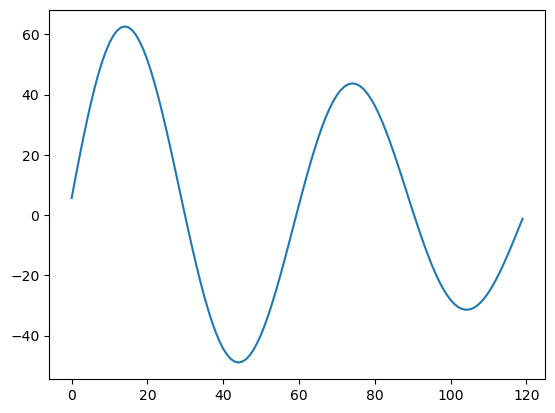

In [9]:
params = {}
T = np.pi * 1.51
#params["tau"] = np.array([1.0, 2.0, 1.0]) * (T / 8)
params = np.ones(hyperparams["ndiscr_per_step"]) * 0.1

args = {}
ev_floquet(params, args)

plt.plot(grad_loss(params, args)[:])

In [10]:
print(loss(params, args))

result = minimize(loss, params, args, method="BFGS", 
                  jac=grad_loss)#, options={"maxiter":100})

print(result.fun)

-28.736027
-82.08064270019531
